In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os, random, time, sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms as T
from torchvision.models import resnet50, ResNet50_Weights

In [9]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Používam:", device)

Používam: cpu


In [11]:
ROOT_DIR = '/content/drive/My Drive/ColabNotebooks'
DATA_DIR = os.path.join(ROOT_DIR, "data", "animals")
LABELS_CSV = os.path.join(ROOT_DIR, "data", "labels.csv")

In [12]:
class AnimalDataset(Dataset):

    def __init__(self, root_dir, labels_df, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels_df = labels_df.reset_index(drop=True)  # pre istotu

        # Vytvor mapovanie image -> encoded_label
        self.paths = self.labels_df["image_name"].tolist()
        self.labels = self.labels_df["category_enc"].tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        rel_path = self.paths[idx]
        full_path = os.path.join(self.root_dir, rel_path)
        img = Image.open(full_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = int(self.labels[idx])  # ako LongTensor
        return img, label


In [13]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [14]:
labels_df = pd.read_csv(LABELS_CSV)
# enkóduj textové kategórie na čísla
encoder = LabelEncoder()
labels_df["category_enc"] = encoder.fit_transform(labels_df["category"])
class_names = list(encoder.classes_)
num_classes = len(class_names)
print("Triedy:", class_names, "| num_classes:", num_classes)

# Dataset
full_dataset = AnimalDataset(DATA_DIR, labels_df, transform=transform)

Triedy: ['Apex Predators', 'Cold-Climate Survivors', 'Flight Masters', 'Other', 'Pack Hunters & Social Strategists', 'Speed Demons', 'Stealth & Shadows', 'Survival Geniuses', 'Tiny Survivors', 'Tough Defenders', 'Underwater Specialists'] | num_classes: 11


In [15]:
n = len(full_dataset)
train_size = int(0.8 * n)
val_size = int(0.1 * n)
test_size = n - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size],
                                         generator=torch.Generator().manual_seed(SEED))

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

print(f"Počty: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

Počty: train=4320, val=540, test=540


In [16]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 37.4MB/s]


In [17]:
for p in model.parameters():
    p.requires_grad = False

In [18]:
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS = 5

In [20]:
history = {
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc":  []
}

In [21]:
def epoch_pass(loader, train=False):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, correct, total = 0.0, 0, 0

    with torch.set_grad_enabled(train):
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += X.size(0)

    avg_loss = total_loss / total if total else 0.0
    acc = 100.0 * correct / total if total else 0.0
    return avg_loss, acc

In [22]:
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = epoch_pass(train_loader, train=True)
    val_loss, val_acc = epoch_pass(val_loader,   train=False)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={tr_loss:.4f} val_loss={val_loss:.4f} | "
          f"train_acc={tr_acc:.1f}% val_acc={val_acc:.1f}%")

print(f"Hotovo za {time.time()-start:.1f}s")

Epoch 01/5 | train_loss=1.3328 val_loss=0.9241 | train_acc=61.4% val_acc=79.1%
Epoch 02/5 | train_loss=0.6911 val_loss=0.6182 | train_acc=84.0% val_acc=85.9%
Epoch 03/5 | train_loss=0.4714 val_loss=0.4846 | train_acc=89.6% val_acc=88.1%
Epoch 04/5 | train_loss=0.3625 val_loss=0.4029 | train_acc=92.0% val_acc=89.4%
Epoch 05/5 | train_loss=0.2908 val_loss=0.3621 | train_acc=94.0% val_acc=90.6%
Hotovo za 9080.4s


TEST: loss=0.3838 | acc=90.4%


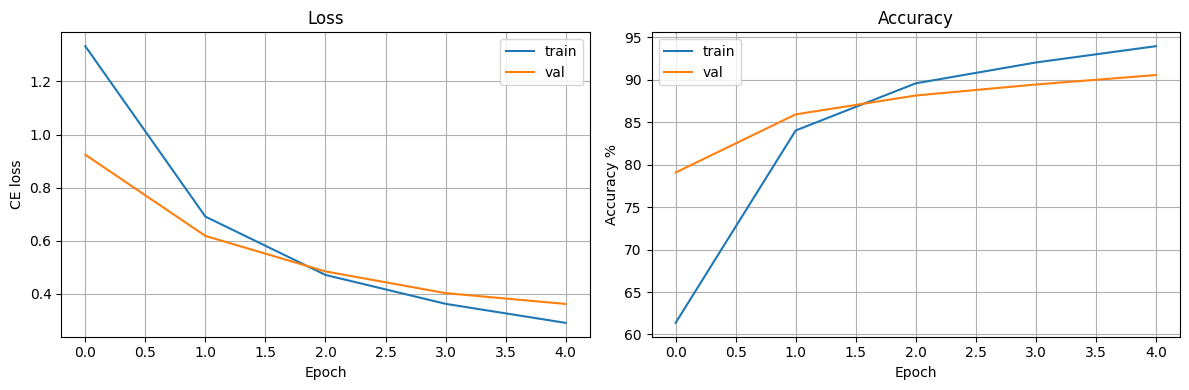

In [23]:
test_loss, test_acc = epoch_pass(test_loader, train=False)
print(f"TEST: loss={test_loss:.4f} | acc={test_acc:.1f}%")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"],   label="val")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("CE loss"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"],   label="val")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy %"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


torch.save({"model_state": model.state_dict(),
            "classes": class_names}, os.path.join(ROOT_DIR, "animals_resnet50.pth"))

In [ ]:
def denorm(img_tensor):

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    img = (img * std) + mean
    return np.clip(img, 0, 1)

In [25]:
def predict_random_from_test(kusov=5):
    model.eval()

    idxs = random.sample(range(len(test_ds)), k=min(kusov, len(test_ds)))
    plt.figure(figsize=(4*kusov, 4))
    for p, i in enumerate(idxs, start=1):
        img, y_true = test_ds[i]
        with torch.no_grad():
            logits = model(img.unsqueeze(0).to(device))
            pred_id = int(logits.argmax(1).item())
        y_name = class_names[y_true]
        p_name = class_names[pred_id]

        plt.subplot(1, kusov, p)
        plt.imshow(denorm(img))
        plt.axis("off")
        plt.title(f"GT: {y_name}\nPred: {p_name}")
    plt.tight_layout()
    plt.show()

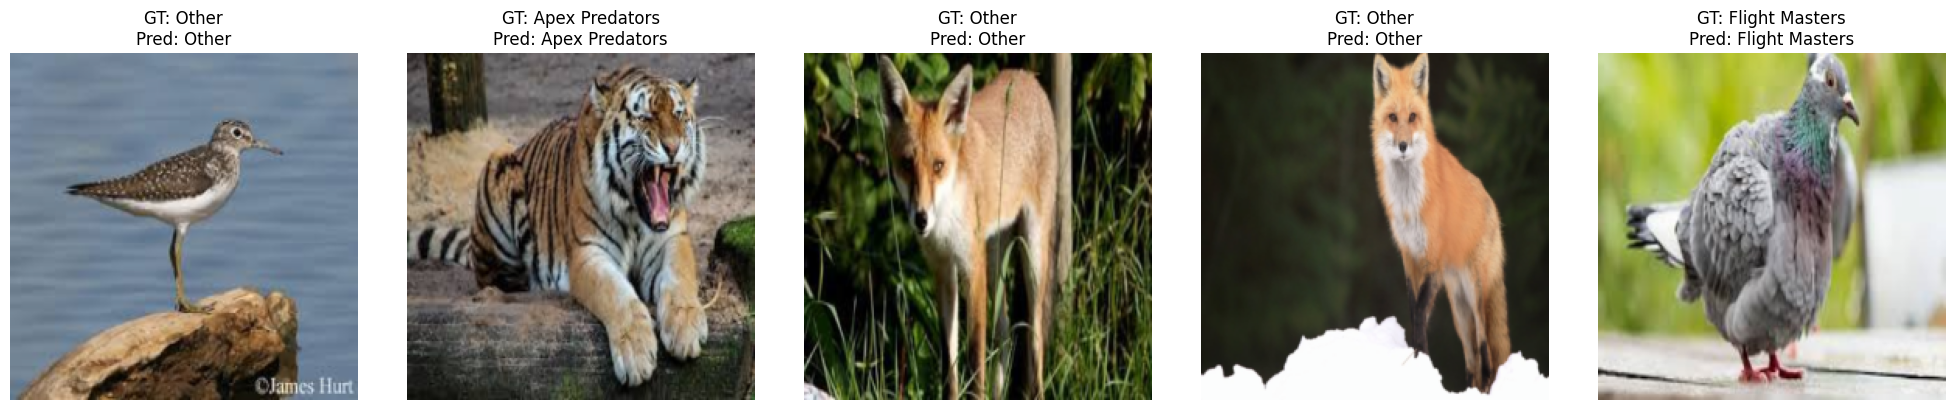

In [26]:
predict_random_from_test(kusov=5)